In [2]:
import pylablib

In [3]:
from pylablib.devices import Thorlabs

# List available APT devices
devices = Thorlabs.list_kinesis_devices()
print("Available devices:", devices)



Available devices: [('83812453', 'APT DC Motor Controller'), ('83829778', 'APT DC Motor Controller'), ('83813170', 'APT DC Motor Controller'), ('83815134', 'APT DC Motor Controller')]


In [4]:
motor_z = Thorlabs.KinesisMotor('83812453')

In [5]:
from pypylon import pylon

tl_factory = pylon.TlFactory.GetInstance()

# Create a device info object and set the IP address
device_info = pylon.DeviceInfo()
device_info.SetDeviceClass("BaslerGigE")  # Ensure we target GigE cameras
device_info.SetIpAddress("192.168.10.212")

# Try to create the camera object
camera = pylon.InstantCamera(tl_factory.CreateDevice(device_info))



In [6]:
camera.Open()
print(f"Connected to camera: {camera.GetDeviceInfo().GetModelName()}")

Connected to camera: a2A1920-51gcBAS


In [7]:
# Acquire one image from the camera
# Set exposure time to minimum (19 microseconds)
camera.ExposureTime.SetValue(200)
print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
camera.StartGrabbingMax(1)
grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

if grab_result.GrabSucceeded():
    image = grab_result.Array
    print(f"Image acquired successfully. Shape: {image.shape}")
else:
    print("Image grab failed")

grab_result.Release()
camera.StopGrabbing()

Exposure time set to: 200.0 µs
Image acquired successfully. Shape: (1200, 1920)


In [8]:
def acquire_and_plot_image(camera, exposure_time_us=200, unit='um', scalebar_length_um=100, figsize=(6,4), title=None):
    """
    Acquire one image from the camera and plot it with physical axes.
    
    Parameters:
    -----------
    camera : pypylon.pylon.InstantCamera
        The camera instance to acquire from
    exposure_time_us : float, optional
        Exposure time in microseconds (default: 19)
    unit : str, optional
        'um' or 'mm' for axis units (default: 'um')
    scalebar_length_um : float, optional
        Length of scalebar in micrometers (default: 100)
    figsize : tuple, optional
        Figure size (default: (6,4))
    title : str, optional
        Custom title for the plot. If None, uses default format (default: None)
    
    Returns:
    --------
    image : numpy.ndarray
        The acquired image
    pixel_size_um : float
        The pixel size in micrometers
    """
    import numpy as np
    from matplotlib import pyplot as plt
    
    # Set exposure and acquire
    camera.ExposureTime.SetValue(exposure_time_us)
    # print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
    camera.StartGrabbingMax(1)
    grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    
    if grab_result.GrabSucceeded():
        image = grab_result.Array
        # print(f"Image acquired successfully. Shape: {image.shape}")
    else:
        print("Image grab failed")
        grab_result.Release()
        camera.StopGrabbing()
        return None, None
    
    grab_result.Release()
    camera.StopGrabbing()
    
    # Determine pixel size
    def _try_get_node_value(nodemap, candidates):
        for name in candidates:
            try:
                node = nodemap.GetNode(name)
                if node is not None:
                    try:
                        val = node.GetValue()
                    except Exception:
                        try:
                            val = float(node.ToString())
                        except Exception:
                            val = None
                    if val is not None:
                        return float(val)
            except Exception:
                continue
        return None
    
    model = camera.GetDeviceInfo().GetModelName()
    pixel_size_um = None
    
    if any(k in model for k in ("a2A1920-51gc", "a2A1920-51", "IMX392")):
        pixel_size_um = 3.45
    
    if pixel_size_um is None:
        try:
            nodemap = camera.GetNodeMap()
            pixel_size_um = _try_get_node_value(nodemap, ["PixelSize", "PixelSizeX", "PixelSizeUm", "PixelPitch"])
            if pixel_size_um is None:
                sensor_width = _try_get_node_value(nodemap, ["SensorWidth", "SensorWidth_mm", "SensorWidth_um"])
                if sensor_width is not None:
                    sensor_width_mm = sensor_width if sensor_width < 10 else sensor_width / 1000.0
                    pixel_size_um = (sensor_width_mm * 1000.0) / image.shape[1]
        except Exception:
            pass
    
    if pixel_size_um is None:
        try:
            pixel_size_um = float(input("Pixel size (µm) not found. Enter pixel size in micrometers: ").strip())
        except Exception:
            raise RuntimeError("Pixel size not available from camera; please provide it manually.")
    
    # print(f"Camera model: {model}")
    # print(f"Using pixel size: {pixel_size_um:.3f} µm (X/Y assumed equal)")
    
    # Plot with physical axes
    def add_scalebar(ax, length_um, pixel_size_um, location='lower right', color='white', fontsize=10):
        length_data = length_um
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if location == 'lower right':
            x = xlim[1] - (xlim[1] - xlim[0]) * 0.05 - length_data
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        else:
            x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        ax.plot([x, x + length_data], [y, y], color=color, linewidth=3)
        ax.text(x + length_data / 2, y + (ylim[1] - ylim[0]) * 0.02, f"{length_um:g} µm",
                color=color, ha='center', va='bottom', fontsize=fontsize)
    
    h, w = image.shape[:2]
    if unit == 'um':
        x_max = w * pixel_size_um
        y_max = h * pixel_size_um
        xlabel, ylabel = 'X (µm)', 'Y (µm)'
    elif unit == 'mm':
        x_max = w * pixel_size_um / 1000.0
        y_max = h * pixel_size_um / 1000.0
        xlabel, ylabel = 'X (mm)', 'Y (mm)'
    else:
        raise ValueError("unit must be 'um' or 'mm'")
    
    extent = (0, x_max, 0, y_max)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None, extent=extent, origin='lower')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Use custom title if provided, otherwise use default format
    if title is None:
        plt.title(f"{model} — pixel {pixel_size_um:.2f} µm")
    else:
        plt.title(title)
    
    plt.tight_layout()
    
    try:
        add_scalebar(ax, scalebar_length_um, pixel_size_um, color='white')
    except Exception:
        pass
    
    plt.show()
    
    return image, pixel_size_um


In [24]:
focus_pos_ct = 192879
print(focus_pos_ct)

192879


In [21]:
motor_z.move_to(192879)

In [10]:
step_mm = (7.2243-7.1836)/1000
print(step_mm)

4.070000000000018e-05


In [22]:
import numpy as np
import os

image, pixel_size_um = acquire_and_plot_image(camera, title='Image at focus position {:.3f} mm'.format(focus_pos_ct))
# Ensure the directory exists
save_dir = os.path.join("../data/Topolino_20260206")
os.makedirs(save_dir, exist_ok=True)

# Save the image as "001.000.npy" in the specified folder
np.save(os.path.join(save_dir, "Topolino_20260206_001_001.npy"), image)


In [ ]:
img = np.load('focus_image.npy')
np.max(img)

# saturated if 4096


4059

Saved Topolino_20260206_001_001.npy at position 191.8790 mm


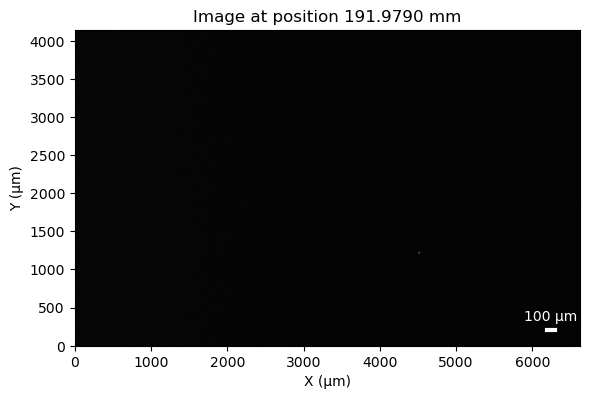

Saved Topolino_20260206_001_002.npy at position 191.9790 mm


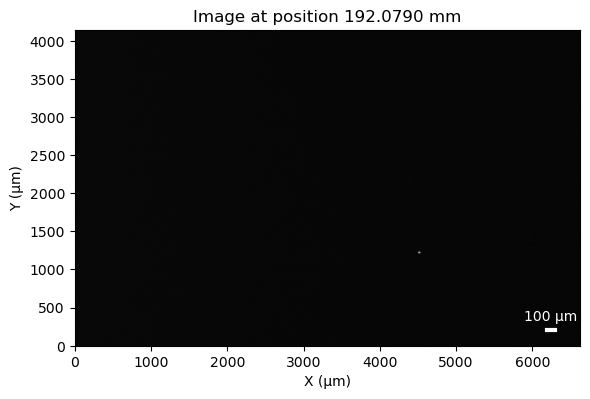

Saved Topolino_20260206_001_003.npy at position 192.0790 mm


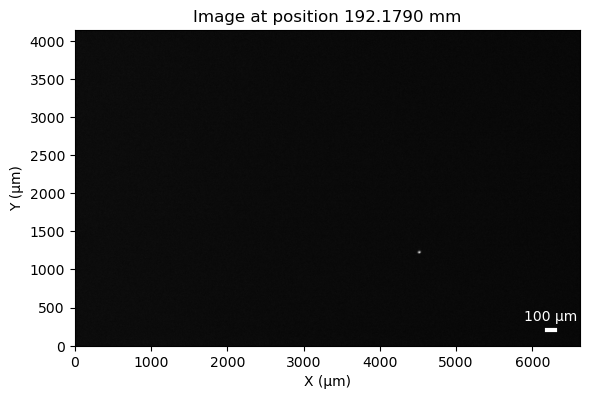

Saved Topolino_20260206_001_004.npy at position 192.1790 mm


Saved Topolino_20260206_001_005.npy at position 192.2790 mm


Saved Topolino_20260206_001_006.npy at position 192.3790 mm


Saved Topolino_20260206_001_007.npy at position 192.4790 mm


Saved Topolino_20260206_001_008.npy at position 192.5790 mm


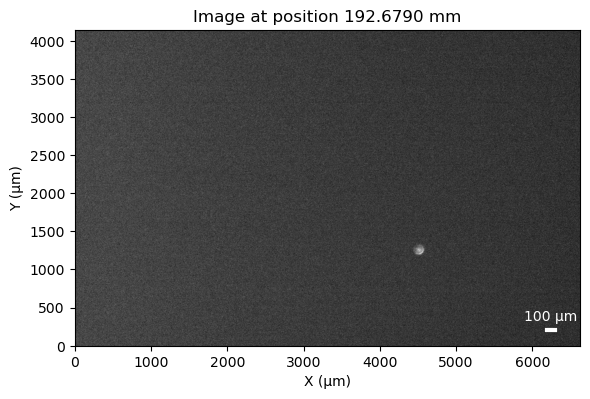

Saved Topolino_20260206_001_009.npy at position 192.6790 mm


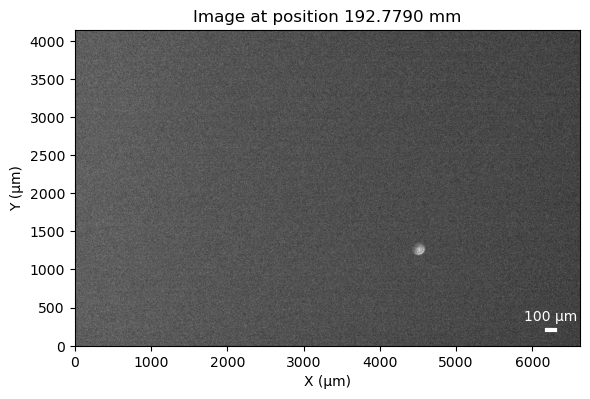

Saved Topolino_20260206_001_010.npy at position 192.7790 mm


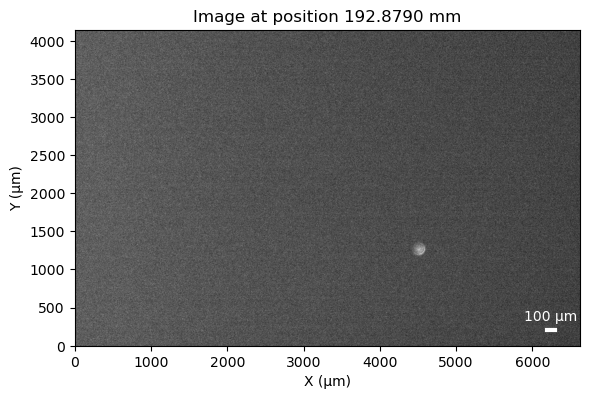

Saved Topolino_20260206_001_011.npy at position 192.8790 mm


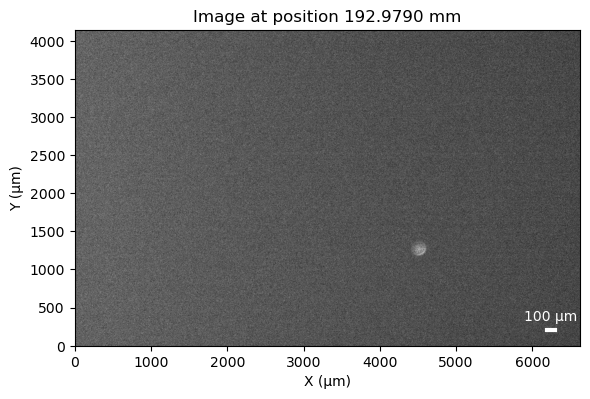

Saved Topolino_20260206_001_012.npy at position 192.9790 mm


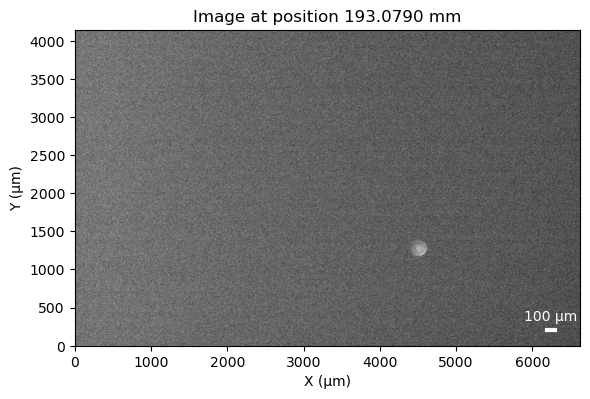

Saved Topolino_20260206_001_013.npy at position 193.0790 mm


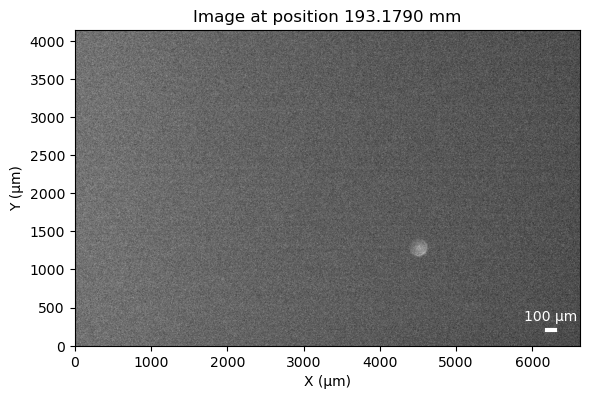

Saved Topolino_20260206_001_014.npy at position 193.1790 mm


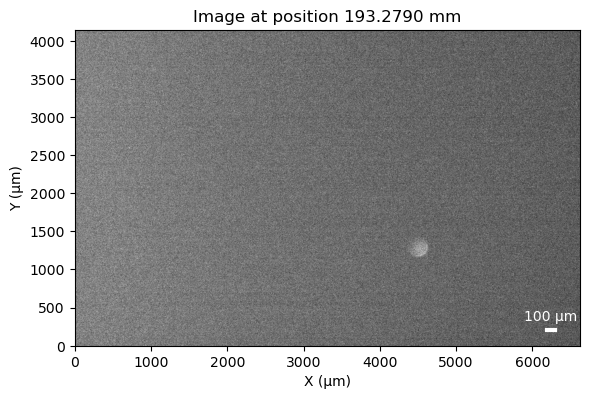

Saved Topolino_20260206_001_015.npy at position 193.2790 mm


Saved Topolino_20260206_001_016.npy at position 193.3790 mm


Saved Topolino_20260206_001_017.npy at position 193.4790 mm


Saved Topolino_20260206_001_018.npy at position 193.5790 mm


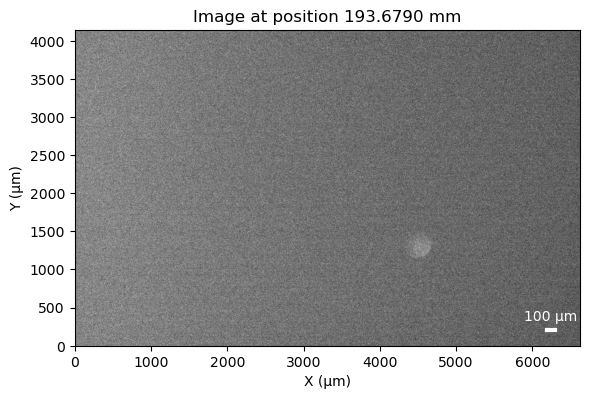

Saved Topolino_20260206_001_019.npy at position 193.6790 mm


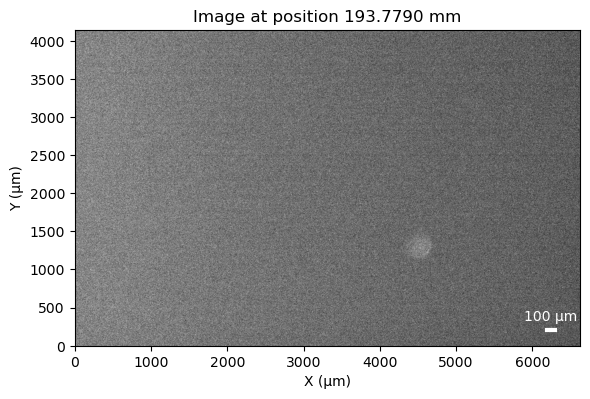

Saved Topolino_20260206_001_020.npy at position 193.7790 mm


Saved Topolino_20260206_001_021.npy at position 193.8790 mm
Returned to focus position: 192.8790 mm


In [25]:
# Collect 21 data points from -1mm to +1mm around focus position
focus_pos_mm = focus_pos_ct / 1000.0  # Convert to mm
start_pos_mm = focus_pos_mm - 1.0
end_pos_mm = focus_pos_mm + 1.0

# Create 21 evenly spaced positions
positions_mm = np.linspace(start_pos_mm, end_pos_mm, 21)

for i, pos_mm in enumerate(positions_mm, start=1):
    # Move motor to position
    motor_z.move_to(pos_mm)
    
    # Acquire and plot image
    image, _ = acquire_and_plot_image(camera, title=f'Image at position {pos_mm:.4f} mm')
    
    # Save image with sequential numbering (001, 002, 003, ...)
    filename = f"Topolino_20260206_001_{i:03d}.npy"
    np.save(os.path.join(save_dir, filename), image)
    print(f"Saved {filename} at position {pos_mm:.4f} mm")
    one_dim_sum = np.sum(image, axis=0)
    np.save(os.path.join(save_dir, f"one_dim_sum_{i:03d}.npy"), one_dim_sum)

# Return to focus position
motor_z.move_to(focus_pos_mm)
print(f"Returned to focus position: {focus_pos_mm:.4f} mm")

In [28]:
import matplotlib.pyplot as plt

# Assuming one_dim_sum and positions_mm are already defined
I_z = np.zeros((len(one_dim_sum), len(positions_mm)))
for idx, pos in enumerate(positions_mm):
    I_z[:, idx] = np.load(os.path.join(save_dir, f"one_dim_sum_{idx+1:03d}.npy"))
    I_z[:, idx] /= np.max(I_z[:, idx])  # normalize

plt.figure(figsize=(12, 8))
y_extent = len(one_dim_sum) * pixel_size_um / 1000  # Y axis in mm
plt.imshow(I_z, extent=[0, y_extent, positions_mm[0], positions_mm[-1]], aspect='auto', origin='lower')
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.title('Intensity map along Y for Z positions')
plt.colorbar(label='Normalized Intensity')
plt.show()

In [29]:
total_range_mm = 2  # 0 to 2
step_size_mm = total_range_mm / 20  # 21 points
step_size_counts = int(step_size_mm / step_mm)

In [ ]:
I_z = np.zeros((len(one_dim_sum), 21))
plt.figure(figsize=(12, 8))
for i in range(21):
    position_mm = -2.0 + i * step_size_mm
    I_z[:,i] = np.load(os.path.join(save_dir, f"one_dim_sum_{i+1:03d}.npy"))
    I_z[:,i] /= np.max(I_z[:,i])  # normalize for better contrast

plt.imshow(I_z, extent=[0, len(one_dim_sum)*pixel_size_um/1000, -2.0, 2.0], aspect='auto', origin='lower')
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
#plt.title('Intensity map at x=3200 µm for z from -2mm to +2mm')


FileNotFoundError: [Errno 2] No such file or directory: 'one_dim_sum_01.npy'

<Figure size 1200x800 with 0 Axes>